# TCA  (Tranfert componant analysis)

In [1]:
## Ipython magic commands...! 

%matplotlib inline
%load_ext rpy2.ipython

In [2]:
### All the packages we need:
from Traj_creator import Traj_data
from TCA import *
from Mitocheck_Read import MitoCheck_Read
from Randomforest import RandomForest_Autotunner,plot_matrix,Measure,check_rotate

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os.path
import cPickle as pkl

# $X_S$

In [3]:
## Well name

if os.path.isfile("H2B_N_F_0.csv"):
    print "The file existed so I loaded it."
    H2B_N_F_0 = Traj_data(file_name="H2B_N_F_0.csv",pkl_traj_file="./Pkl_file") 
    H2B_N_F_0.caract="Normalized by dividing by first element"

else:    
    H2B_N_F_0=Traj_data()#(pkl_traj_file="/home/pubuntu/Documents/InternWork2/Pkl_file") 

    H2B_N_F_0.extracting(num_str,"both_channels_0015.hdf5",'primary') 
    ## Extracting the hdf5 file for the primary channel (H2b)
    
#    H2B_N_.add_error() ## We had it so that the data won't have to do 0/0

    H2B_N_F_0.Add_traj(normalize=True,all_traj=False,average=False,diff=False)## ,num_traj=10) ## (you can reduce the number of traj)
    ## Adding Alice's work on tracking to have trajectories

    file_loc="0015_PCNA.xml"

    H2B_N_F_0.label_finder(file_loc) 
    ## Finding associated labels by minimizing distance by click and distance of cell

    H2B_N_F_0.renaming_and_merge() 
    ## renaming the labels to have G1=="1", S=="S", G2=="2" and M=="M" 
    #This procedure may take a long time.

    H2B_N_F_0.data.to_csv('H2B_N_F_0.csv',index=False,header=True)

    

if H2B_N_F_0.Var_missing[0] in H2B_N_F_0.train.columns:
    H2B_N_F_0.missing_features_train()
if H2B_N_F_0.Var_missing[0] in H2B_N_F_0.data.columns:
    H2B_N_F_0.missing_features_data()

        
X_S=H2B_N_F_0.train.ix[pd.notnull(H2B_N_F_0.train['traj']),H2B_N_F_0.names+["Type"]]


X_S.dropna(axis=0)
Y_S=X_S["Type"]
X_S=X_S[H2B_N_F_0.names]

The file existed so I loaded it.
Traj_data built
Reader constructed
Updated member Group_of_traj


/home/pubuntu/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (245) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


# $X_T$

In [4]:
MitoCheck = MitoCheck_Read()
MitoCheck.Normalize(division=True,average=False)  

if MitoCheck.Var_missing[0] in MitoCheck.data.columns:
    MitoCheck.missing_features()

X_T=MitoCheck.data[MitoCheck.names]

aux_FilterTraj.py:37: UserWarning: No connexions in trajectory  74on well 315
  warnings.warn('No connexions in trajectory  '+str(traj_n)+'on well '+str(Well))
aux_FilterTraj.py:37: UserWarning: No connexions in trajectory  90on well 315
  warnings.warn('No connexions in trajectory  '+str(traj_n)+'on well '+str(Well))
aux_FilterTraj.py:37: UserWarning: No connexions in trajectory  151on well 315
  warnings.warn('No connexions in trajectory  '+str(traj_n)+'on well '+str(Well))
aux_FilterTraj.py:37: UserWarning: No connexions in trajectory  156on well 315
  warnings.warn('No connexions in trajectory  '+str(traj_n)+'on well '+str(Well))
aux_FilterTraj.py:37: UserWarning: No connexions in trajectory  439on well 315
  warnings.warn('No connexions in trajectory  '+str(traj_n)+'on well '+str(Well))
aux_FilterTraj.py:37: UserWarning: No connexions in trajectory  152on well 074
  warnings.warn('No connexions in trajectory  '+str(traj_n)+'on well '+str(Well))
aux_FilterTraj.py:37: UserWarning: N

MitoCheck_Read()
Updated member Group_of_traj
Because of missing values I adjusted it, in the case X_t/X_0


aux_FilterTraj.py:37: UserWarning: No connexions in trajectory  46on well 352
  warnings.warn('No connexions in trajectory  '+str(traj_n)+'on well '+str(Well))
aux_FilterTraj.py:37: UserWarning: No connexions in trajectory  49on well 352
  warnings.warn('No connexions in trajectory  '+str(traj_n)+'on well '+str(Well))
aux_FilterTraj.py:37: UserWarning: No connexions in trajectory  62on well 352
  warnings.warn('No connexions in trajectory  '+str(traj_n)+'on well '+str(Well))


# Getting matrix W

## Rescaling the data

As we are going to be using a kernel trick we have to normalize the data, in particular as we are interested in differences in distributions it is interesting to set the data as it will have 0 mean and variance 1.

In particular: $$X'_S=\frac{X_S-\bar{X_S}}{\sqrt{V(X_S)}}$$ 

And : $$X'_T=\frac{X_T-\bar{X_T}}{\sqrt{V(X_T)}}$$

In [5]:
## We get ride of features where their variance is 0
Std_X_S=np.std(X_S,axis=0)
print "number of features in the data before: %d" %(X_S.shape[1])
new_names_X_S=[el for el in X_S.columns if np.std(X_S[el])!=0]
new_names_X_T=[el for el in X_T.columns if np.std(X_T[el])!=0]
if new_names_X_S==new_names_X_T:
    new_names = new_names_X_T  
else:
    new_names = list(set(new_names_X_S).intersection(new_names_X_T))
X_S=X_S[new_names]
X_T=X_T[new_names]
print "number of features in the data after : %d" %(X_S.shape[1])

# variable granu_open_area_5 is having difficulties as the mean of granu_open_area_5 is inf,
# so infinite values have to be removed, ask Thomas about it
n_orig=X_T.shape[0]

X_T=X_T.replace([np.inf, -np.inf], np.nan)
X_T=X_T.dropna(axis=0, how='any')

mean_X_S=np.mean(X_S,axis=0)
Std_X_S =np.std(X_S,axis=0)

mean_X_T=np.mean(X_T,axis=0)
Std_X_T =np.std(X_T,axis=0)

X_S=X_S.apply(lambda x: (x-mean_X_S)/Std_X_S,axis=1)
X_T=X_T.apply(lambda x: (x-mean_X_T)/Std_X_T,axis=1)

#Taking inf values and missing values

X_T=X_T.dropna(axis=0, how='any')
n_late=X_T.shape[0]
print "number of instances in the data before: %d" %(n_orig)
print "number of instances in the data after : %d" %(n_late)

number of features in the data before: 235
number of features in the data after : 233
number of instances in the data before: 18594
number of instances in the data after : 18539


[  1.75538271e+04  -9.22845266e+02   1.06631119e+01]
14.6177664708


,ch_acd,ch_area_ratio,ch_cc,ch_max_val_0,ch_max_val_1,ch_max_val_2,ch_mean_area,ch_rugosity,ch_thresh_cc,ch_variance_area,...,n_wavg,n_wdist,n_wiavg,perimeter,princ_gyration_ratio,princ_gyration_x,princ_gyration_y,roisize,skewness_x,skewness_y
694,-0.096709,-0.355476,-0.551198,-0.230200,-0.146447,0.484801,-0.525574,0.323021,-0.296301,-0.303885,...,-0.836265,-1.423477,0.373425,-1.233510,0.423193,-0.524627,0.443096,-1.269993,0.028571,-1.141180
697,0.667136,-0.070994,-0.355319,0.349353,0.466227,0.455380,-0.414826,-0.982743,-0.296301,-0.182379,...,-0.985265,-1.292565,1.382492,-0.987585,-0.368770,0.221780,-0.324629,-1.246807,-0.445082,-0.041552
994,1.052098,-0.003799,-0.942955,-0.008749,0.538384,0.572446,-0.592024,0.323021,-0.296301,-0.313074,...,-2.133709,-2.557506,3.070595,-2.818727,-0.397247,0.226630,-0.378904,-2.441878,-0.361927,-0.191468
1381,0.273283,-0.226280,-0.942955,0.789166,-0.793203,-0.513958,-0.126879,0.323021,-0.296301,0.137211,...,-0.550119,-1.117712,0.614450,-0.881239,-0.377584,0.201060,-0.363921,-1.126625,-0.314353,-1.292254
1387,-0.098630,-0.306184,0.526135,-0.442674,0.518894,0.540825,-0.503425,-0.982743,-0.296301,-0.304906,...,0.264669,-0.422050,0.288946,0.022700,0.331971,-0.421882,0.386367,-0.249776,-0.126178,1.367976
1462,0.218263,-0.241577,-0.355319,-0.314056,0.365955,0.292703,-0.547724,1.152565,-0.296301,-0.304906,...,-1.347560,-1.362654,0.498342,-1.085682,1.087628,-1.000385,1.098433,-1.064414,-0.359089,1.054463
2460,0.052445,-0.246765,-0.355319,-0.051694,-0.051270,0.091364,-0.459125,0.323021,-0.296301,-0.254262,...,-0.273604,-0.686934,0.061977,-0.294122,-0.173500,0.013246,-0.138752,-0.677818,0.680556,-1.252662
2464,0.127559,0.553178,0.232317,-0.625555,-0.050241,-0.382519,-0.592024,-0.982743,-0.296301,-0.313074,...,0.378456,0.053980,-0.195328,0.275272,1.124505,-1.034513,1.120839,0.330687,0.331175,0.229003
2485,-0.647910,-1.749428,1.407589,0.695167,1.554247,0.337003,0.803410,2.353875,-0.296301,-0.211990,...,-1.425170,-0.809320,0.246213,-0.705104,-1.414098,1.555434,-1.428159,-1.101691,-0.519999,-0.070413
2701,1.040403,-0.004626,-0.551198,0.454341,1.410387,0.369924,-0.293002,-0.814258,-0.296301,-0.122392,...,-1.251838,-1.174856,0.467622,-1.227735,-0.237961,0.053765,-0.227756,-1.132186,-1.085309,0.571527


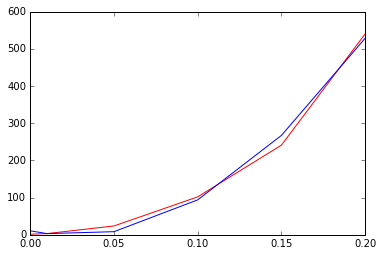

In [15]:
x=[0,0.01,0.05,0.1,0.15,0.2]
y=[1.53,3.29,23.8,102,241,540]
deg=2
t=np.polyfit(x, y, deg) 
def f(x):
    return(t[0]*x*x+t[1]*x+t[2])
y_false=[f(x[i]) for i in range(len(y))]
print t
plt.plot(x,y,'-r')
plt.plot(x,y_false,'-b')
print f(0.25)/60

X_S

In [19]:

execfile('TCA.py')
m    =233     # dimension of the new feature space
mu   =0.1     # weigth scalar to tune (maybe)
sigma=20      # hyper parameter for the laplacien matrix, linked to lambda
lamb =0.001   # trandeof parameter
gamma=0.5     # tradeof parameter that balances the label dependence and data variance terms.
kernel_para=10   # hyper parameter for the gaussian kernel
p    =2       # p norm used to calculate the distances between samples
random_sample_T=0.05 # Fraction of the task domain to use
"""
W_eigenValues,W_eigenVectors,K,LA,K_hat_y,data_used=SSTCA(X_S,Y_S,X_T,
                                             m=m,
                                             mu=mu,
                                             lamb=lamb,
                                             kernel_para=kernel_para,
                                             p=p,
                                             sigma=sigma,
                                             gamma=gamma,
                                             random_sample_T=random_sample_T)
"""
%time W_eigenValues,W_eigenVectors,K,LA,K_hat_y,data_used=SSTCA(X_S,Y_S,X_T,m=m,mu=mu,lamb=lamb,kernel_para=kernel_para,p=p,sigma=sigma,gamma=gamma,random_sample_T=random_sample_T)



926 samples taken from the task domain
CPU times: user 28.7 s, sys: 7.63 s, total: 36.3 s
Wall time: 15.4 s


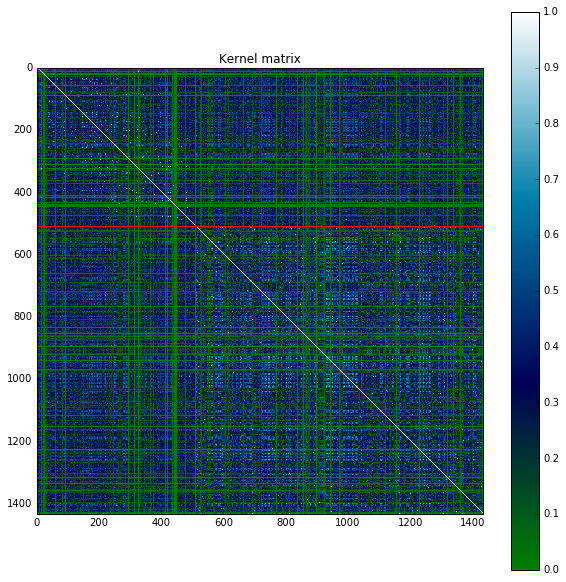

In [20]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10 #plot size

K=np.array(K)
fig = plt.figure()
plt.imshow(K, interpolation='nearest', cmap=plt.cm.ocean)
plt.axis([0, K.shape[0] , K.shape[1], 0]) 
plt.title("Kernel matrix")
plt.colorbar()
plt.axhline(y=X_S.shape[0],color='r')
# draw a default vline at x=1 that spans the yrange
plt.axvline(x=X_S.shape[0],color='r')
plt.show()      


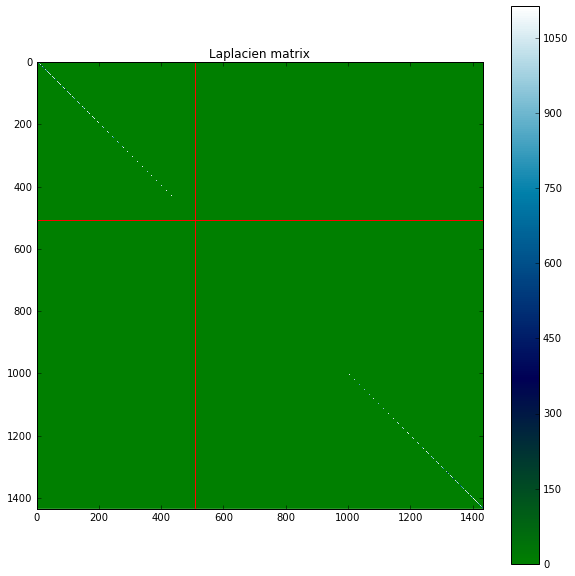

In [21]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10 #plot size

LA=np.array(LA)
fig = plt.figure()
plt.imshow(LA, interpolation='nearest', cmap=plt.cm.ocean)
plt.axis([0, LA.shape[0] , LA.shape[1], 0]) 
plt.title("Laplacien matrix")
plt.colorbar()
plt.axhline(y=X_S.shape[0],color='r')
# draw a default vline at x=1 that spans the yrange
plt.axvline(x=X_S.shape[0],color='r')
plt.show()      


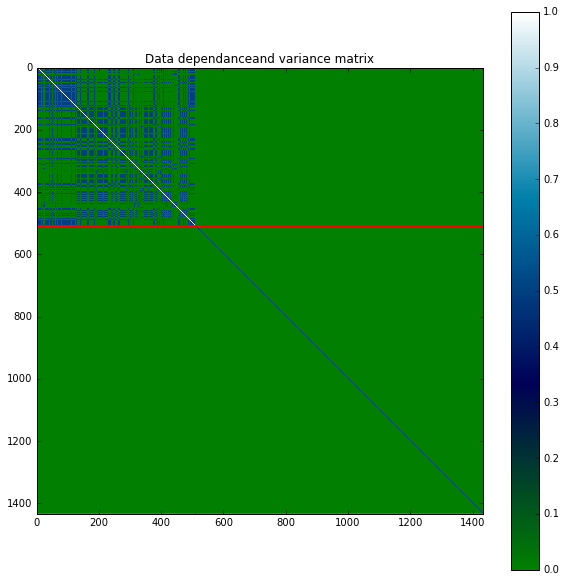

In [22]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10 #plot size

K_hat_y=np.array(K_hat_y)
fig = plt.figure()
plt.imshow(K_hat_y, interpolation='nearest', cmap=plt.cm.ocean)
plt.axis([0, K_hat_y.shape[0] , K_hat_y.shape[1], 0])
plt.title("Data dependanceand variance matrix")
plt.colorbar()
plt.axhline(y=X_S.shape[0],color='r')
# draw a default vline at x=1 that spans the yrange
plt.axvline(x=X_S.shape[0],color='r')
plt.show()      


In [23]:
## Because of the inversion problem we have a null imaginary part, just to be sure it
## doesn't mess anything up in the next part...
W_eigenVectors=sp.real(W_eigenVectors)

training=(sp.mat(W_eigenVectors.T)*sp.mat(K)).T[0:508]
train=pd.DataFrame(training)
train.head()

,0,1,2,3,4,5,6,7,8,9,...,223,224,225,226,227,228,229,230,231,232
0,0.067853,-0.058759,0.092189,-0.030430,-0.044633,-0.044633,0.015037,0.015037,0.051030,0.051030,...,-0.009390,-0.004435,-0.004435,0.005388,0.005388,0.011048,0.011048,-0.009810,-0.009810,0.000471
1,0.066381,-0.045759,0.098992,-0.018511,-0.014183,-0.014183,-0.011665,-0.011665,0.011965,0.011965,...,-0.040229,0.009327,0.009327,-0.011676,-0.011676,-0.019263,-0.019263,-0.028575,-0.028575,0.002186
2,-2.551734,-0.263324,0.215202,-0.034835,-0.033528,-0.033528,0.017273,0.017273,0.032957,0.032957,...,0.032399,-0.008098,-0.008098,0.007632,0.007632,0.019135,0.019135,0.022370,0.022370,-0.009197
3,0.067998,-0.060775,0.101684,-0.031081,-0.030283,-0.030283,0.002805,0.002805,0.034918,0.034918,...,-0.013337,-0.012216,-0.012216,0.013954,0.013954,0.006215,0.006215,-0.006596,-0.006596,-0.002996
4,0.069853,-0.068982,0.123496,-0.041952,-0.002134,-0.002134,0.006361,0.006361,-0.005267,-0.005267,...,-0.029266,0.012396,0.012396,0.003818,0.003818,-0.015858,-0.015858,-0.032808,-0.032808,0.006321


Processing time: 8.475782 in sec


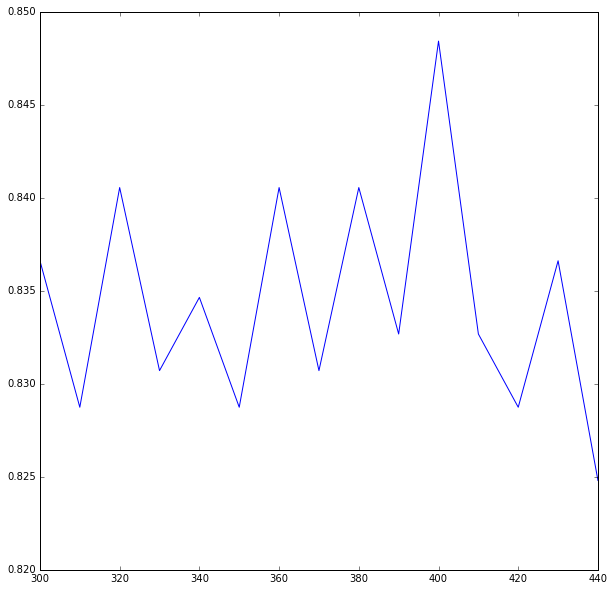

In [24]:
## Results for m=40

kfold=5
values=[300 + i*10 for i in range(15)]

model=RandomForest_Autotunner(values,n_jobs=2)

model.tunning(train,Y_S,kfold,plot=True,fit_new_model=True,opti=True) #to get cm
plt.show()

185 samples taken from the task domain
Processing time: 159.598438 in sec


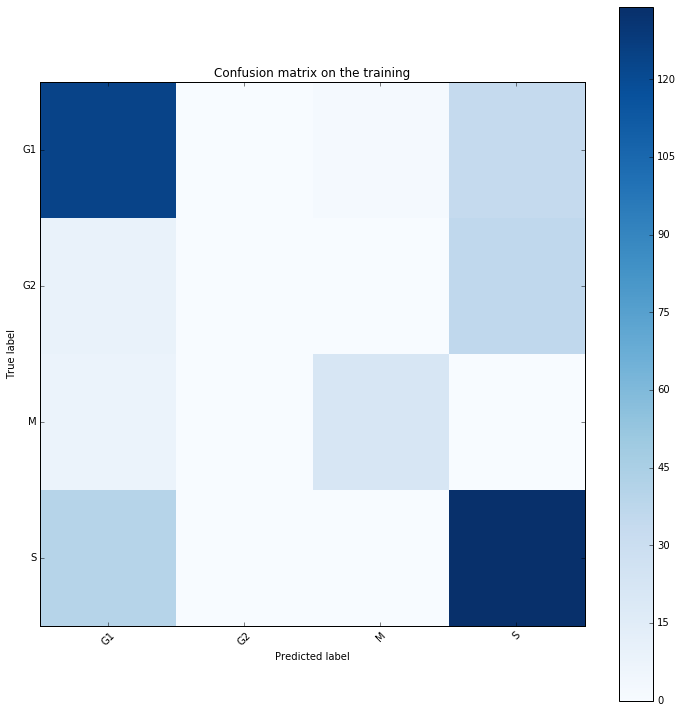

> /home/pubuntu/Documents/InternWork2/TCA.py(206)getting_kernel_projection()
-> 
(Pdb) c


'\nW_eigenValues,W_eigenVectors,K,LA,K_hat_y,data_used=SSTCA(X_S,Y_S,X_T,\n                                             m=m,\n                                             mu=mu,\n                                             lamb=lamb,\n                                             kernel_para=kernel_para,\n                                             p=p,\n                                             sigma=sigma,\n                                             gamma=gamma,\n                                             random_sample_T=random_sample_T)\n                                             '

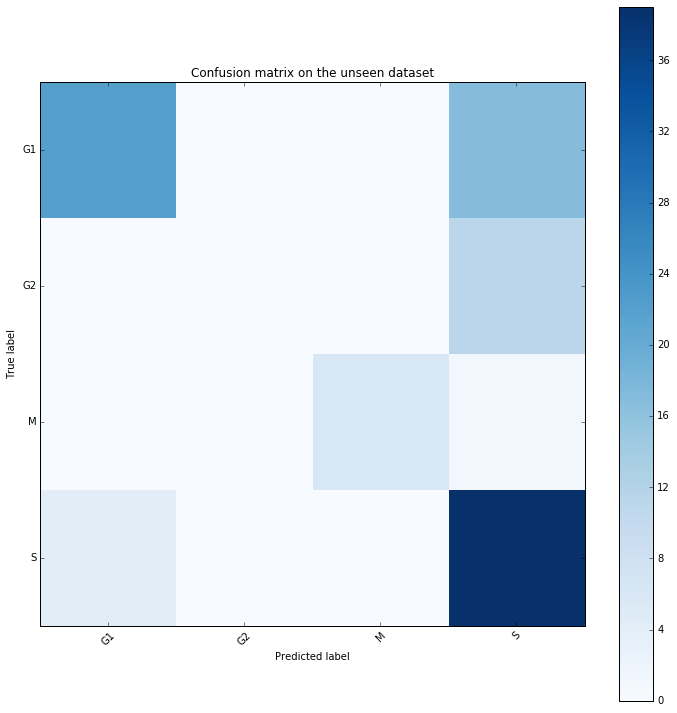

In [61]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import confusion_matrix


m    =233     # dimension of the new feature space
mu   =0.1     # weigth scalar to tune (maybe)
sigma=10      # hyper parameter for the laplacien matrix, linked to lambda
lamb =0.001   # trandeof parameter
gamma=1     # tradeof parameter that balances the label dependence and data variance terms.
kernel_para=10   # hyper parameter for the gaussian kernel
p    =2       # p norm used to calculate the distances between samples
random_sample_T=0.01 # Fraction of the task domain to use
kfold=5

y_S=pd.DataFrame(np.array(Y_S))
skf = StratifiedKFold(np.array(y_S[0]), n_folds=kfold,shuffle=True)
n_T=X_T.shape[0]
print str(int(n_T*random_sample_T))+" samples taken from the task domain"
index_sample=np.random.choice([i for i in X_T.index],size=int(n_T*random_sample_T))
X_T_bis=X_T.ix[index_sample,:]


true_index=np.array(X_S.index)

for train_index,test_index in skf:
    train_index=true_index[train_index]
    test_index=true_index[test_index]
    X_train=X_S.ix[train_index,]
    X_test=X_S.ix[test_index,]
    y_train=[Y_S[i] for i in train_index]
    y_test=[Y_S[i] for i in test_index]            

if True:
    W_eigenValues,W_eigenVectors,K,data_used=TCA(X_train,
                                                 X_T_bis,
                                                 m=m,
                                                 mu=0.1,
                                                 kernel_para=10,
                                                 p=2,
                                                 random_sample_T=1)
    W_eigenVectors=sp.real(W_eigenVectors)
    training=(sp.mat(W_eigenVectors.T)*sp.mat(K)).T[0:X_train.shape[0]]
    train=pd.DataFrame(training)
    
    kfold=5
    values=[300 + i*10 for i in range(15)]

    model=RandomForest_Autotunner(values,n_jobs=2)

    model.tunning(train,y_train,kfold,plot=True,fit_new_model=True,opti=False) #to get cm
    plot_matrix(model.cm,title="Confusion matrix on the training")
    plt.show()
    
    data_used=pd.DataFrame(data_used,columns=X_test.columns)
    X_test=getting_kernel_projection(X_test,data_used,m,W_eigenVectors,kernel_para,p)
    
    y_new=model.predict(X_test[train.columns])
    cm_new=confusion_matrix(y_test,y_new)
    plot_matrix(cm_new,title="Confusion matrix on the unseen dataset")
"""
W_eigenValues,W_eigenVectors,K,LA,K_hat_y,data_used=SSTCA(X_S,Y_S,X_T,
                                             m=m,
                                             mu=mu,
                                             lamb=lamb,
                                             kernel_para=kernel_para,
                                             p=p,
                                             sigma=sigma,
                                             gamma=gamma,
                                             random_sample_T=random_sample_T)
                                             """

In [59]:
cm_new.trace()


71

In [49]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,223,224,225,226,227,228,229,230,231,232
0,-6.758814,0.171818,-1.211226,-0.299002,-1.042831,1.339877,0.009666,-0.031089,0.012904,0.068277,...,0.005018,0.015245,0.022193,0.015239,0.009867,-0.010932,0.009290,0.009065,-0.009898,-0.008955
1,-3.173231,0.453692,-1.694551,-0.484515,-0.875299,0.906909,-0.357122,-0.169773,0.227286,-0.293967,...,0.040048,0.012249,0.037374,-0.000159,-0.020297,0.022624,0.021578,0.010885,0.018960,-0.008493
2,-6.974509,0.493966,-1.349660,0.551791,-1.161552,0.925342,0.077974,-0.086481,0.231695,0.061266,...,-0.000154,0.002491,0.030971,0.004936,0.003683,-0.023514,0.018366,0.017415,0.008593,-0.010522
3,-5.362765,-0.361316,-0.337826,-0.802421,-0.069260,1.189804,0.089944,-0.246643,-0.206282,-0.459811,...,-0.020162,0.025324,-0.015425,0.030499,0.020273,0.014284,0.009402,0.001578,0.008885,0.001386
4,-7.859665,0.111342,-0.518314,0.856547,-0.943436,0.853484,0.020039,-0.207991,0.257761,0.000282,...,0.004632,0.009687,0.025822,0.000186,0.013420,-0.022623,0.006520,0.016044,0.002899,-0.009929


In [47]:
execfile('TCA.py')

> /home/pubuntu/Documents/InternWork2/TCA.py(206)getting_kernel_projection()
-> data[new_feat]=data.apply(lambda x: new_feature(data_used,W_eigenVectors,x,kernel_para,p,names),axis=1)
(Pdb) c


In [48]:
X_test.head()

,ch_acd,ch_area_ratio,ch_cc,ch_max_val_0,ch_max_val_1,ch_max_val_2,ch_mean_area,ch_rugosity,ch_thresh_cc,ch_variance_area,...,223,224,225,226,227,228,229,230,231,232
994,1.052098,-0.003799,-0.942955,-0.008749,0.538384,0.572446,-0.592024,0.323021,-0.296301,-0.313074,...,0.000038,0.018991,0.032365,0.001185,0.005172,-0.008551,0.005455,0.002678,0.002569,-0.002777
1387,-0.098630,-0.306184,0.526135,-0.442674,0.518894,0.540825,-0.503425,-0.982743,-0.296301,-0.304906,...,0.004604,0.002197,0.024656,-0.007167,0.010707,-0.000266,-0.000197,0.017012,0.003252,-0.000528
2464,0.127559,0.553178,0.232317,-0.625555,-0.050241,-0.382519,-0.592024,-0.982743,-0.296301,-0.313074,...,0.002884,-0.004038,0.019440,-0.005399,0.019092,-0.004933,0.000965,0.012218,-0.000422,0.005451
2701,1.040403,-0.004626,-0.551198,0.454341,1.410387,0.369924,-0.293002,-0.814258,-0.296301,-0.122392,...,0.001113,0.002961,0.029492,0.004386,0.009130,-0.006948,0.015364,0.011565,0.006566,0.000927
4364,0.009210,-0.214766,-0.747077,-0.008749,-1.143883,0.114518,-0.459125,0.323021,-0.296301,-0.239559,...,0.013047,0.006882,0.036008,-0.004070,0.007496,-0.003761,-0.002644,0.005812,0.013202,-0.014538


In [25]:
new_Data[["TCA_" + str(i) for i in range(m)]]

,TCA_0,TCA_1,TCA_2,TCA_3,TCA_4,TCA_5,TCA_6,TCA_7,TCA_8,TCA_9,...,TCA_223,TCA_224,TCA_225,TCA_226,TCA_227,TCA_228,TCA_229,TCA_230,TCA_231,TCA_232
12891,6.070924e-02,-8.088289e-01,5.944455e-01,-7.483552e-01,-6.764521e-01,3.806877e-01,-1.608289e+00,-1.159173e+00,-4.577374e-01,6.852741e-01,...,1.004896e-01,2.434011e-02,-1.170546e-01,9.029052e-02,-5.391289e-02,-1.142885e-01,6.440656e-02,1.977071e-02,-7.697855e-02,1.688618e-01
12895,-1.784551e-10,-9.853722e-10,1.159555e-09,-6.284935e-10,-5.827589e-11,-1.017176e-12,-8.656931e-10,-6.737108e-10,1.661057e-11,1.025803e-09,...,5.176606e-10,6.034342e-10,3.838188e-10,-1.240595e-09,-2.128250e-10,-3.896487e-10,1.423844e-10,1.834737e-10,-7.400606e-10,1.754254e-10
12901,-1.031123e-12,-5.281467e-12,6.081904e-12,-3.115829e-12,-5.384992e-13,-8.151312e-14,-4.518351e-12,-3.262294e-12,1.854322e-13,5.011862e-12,...,2.122834e-12,2.445979e-12,2.279695e-12,-5.253165e-12,-1.108408e-12,-2.174581e-12,5.132080e-13,1.095690e-12,-3.067735e-12,4.271436e-13
12909,-4.981775e-14,-4.262647e-13,4.068192e-13,-2.898774e-13,-1.533373e-13,1.062929e-13,-4.176722e-13,-3.138754e-13,-4.150973e-14,3.301870e-13,...,1.832326e-13,7.698756e-14,-8.346330e-14,-8.327258e-14,-2.471488e-14,-7.768636e-14,1.069014e-14,2.945758e-14,-1.293928e-13,2.435282e-14
12921,-2.898484e-13,-1.728301e-12,1.974996e-12,-1.079234e-12,-1.491087e-13,1.257735e-13,-1.519544e-12,-1.199215e-12,-4.101184e-14,1.802126e-12,...,1.103421e-12,1.079861e-12,3.958611e-13,-1.927207e-12,-2.684614e-13,-6.990460e-13,3.595173e-13,2.560766e-13,-1.427353e-12,3.497862e-13


In [33]:
print sum(X_T.>10000000000000)
print X_T.shape

27028
(18502, 233)


Processing time: 2.427693 in sec


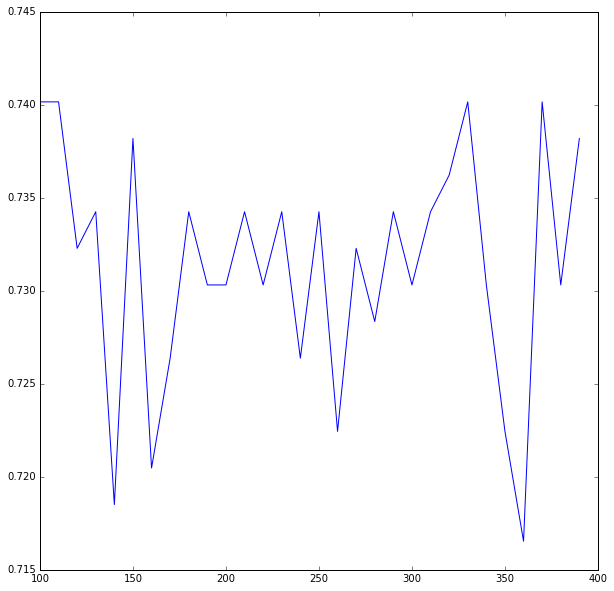

In [19]:
## Results for m=30
m_bis=30

kfold=10
values=[100 + i*10 for i in range(30)]

model=RandomForest_Autotunner(values,n_jobs=7)

model.tunning(train.ix[:,0:m_bis],Y_S,kfold,plot=True,fit_new_model=True,opti=True) #to get cm
plt.show()

Processing time: 3.648226 in sec


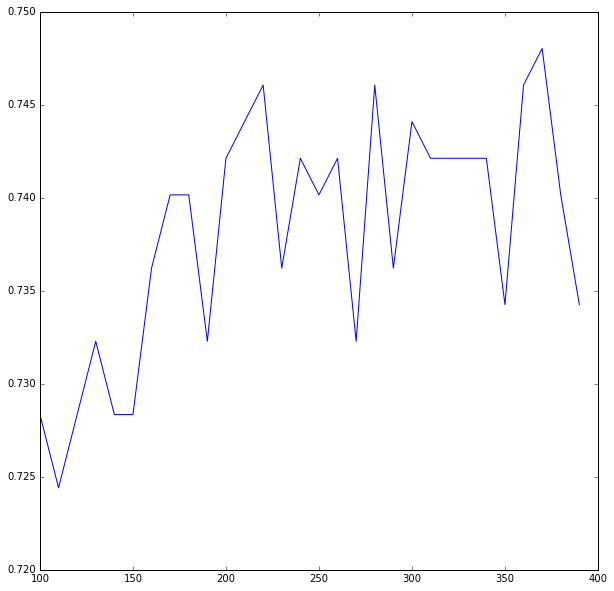

In [20]:
## Results for m=20
m_bis=20

kfold=10
values=[100 + i*10 for i in range(30)]

model=RandomForest_Autotunner(values,n_jobs=7)

model.tunning(train.ix[:,0:m_bis],Y_S,kfold,plot=True,fit_new_model=True,opti=True) #to get cm
plt.show()

Processing time: 2.821912 in sec


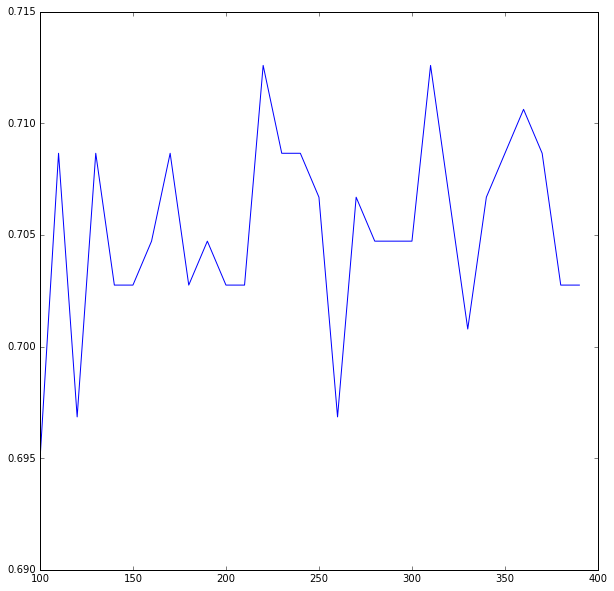

In [21]:
## Results for m=30
m_bis=10

kfold=10
values=[100 + i*10 for i in range(30)]

model=RandomForest_Autotunner(values,n_jobs=7)

model.tunning(train.ix[:,0:m_bis],Y_S,kfold,plot=True,fit_new_model=True,opti=True) #to get cm
plt.show()